<a href="https://colab.research.google.com/github/Nazhan99/Tensorflow_notes/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer Learning with TensorFlow Part 3: Scaling Up (Food Vision Mini)

we have done transfer learning feature extraction and fine-tuning, now it is the time to scale up too all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).

Original food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat is 50.76% accuracy across 101 classes.

In [1]:
#check to see if we are using GPU
!nvidia-smi

Thu Feb 24 03:05:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
## creating helper functions

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-02-24 03:05:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-02-24 03:05:01 (71.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
#import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food classes: working with less data

The data comes from the original food 101 dataset but has been preprocess using image _data_modification

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

--2022-02-24 03:05:04--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 74.125.140.128, 173.194.76.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   113MB/s    in 14s     

2022-02-24 03:05:19 (110 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
train_dir="101_food_classes_10_percent/train/"
test_dir="101_food_classes_10_percent/test/"

In [6]:
#how many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/french_toast'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/baklava'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/churros'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hot_dog'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/takoyaki'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pork_chop'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/caprese_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_p

In [7]:
#setup data inputs
import tensorflow as tf
IMG_SIZE=(224,224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                image_size=IMG_SIZE,
                                                                                label_mode="categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) #dont shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we are going to take:

* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficeintNetB0 backboned-model ( we will create our own output layer)
* compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [8]:
# create checkpoint callback
checkpoint_path="101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [9]:
#create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#setup data augmentation
data_augmentation =Sequential([
                               layers.RandomFlip("horizontal"),
                               layers.RandomRotation(0.2),
                               layers.RandomHeight(0.2),
                               layers.RandomWidth(0.2),
                               layers.RandomZoom(0.2),
                               #layers.Rescaling(1/./255) # rescale input of images to between 0 & 1 reqquired for resnet model
], name="data_augmentation")



In [11]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

#Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs) #augment images (only happens during training phase)
x = base_model(x, training=False) #put the base model in inference mode so weight which need to stay frozen will stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [15]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate= 0.0001),
              metrics=["accuracy"])

history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                            epochs=5, #fit for 5 epochs to this experiment
                                            validation_data=test_data,
                                            validation_steps=int(0.15*len(test_data)), #validate  on only 15% of test data
                                            callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 188s 722ms/step - loss: 4.5127 - accuracy: 0.0338 - val_loss: 4.2335 - val_accuracy: 0.0877
Epoch 2/5
237/237 [==============================] - 144s 605ms/step - loss: 4.0938 - accuracy: 0.1398 - val_loss: 3.9275 - val_accuracy: 0.1925
Epoch 3/5
237/237 [==============================] - 136s 573ms/step - loss: 3.7710 - accuracy: 0.2379 - val_loss: 3.6666 - val_accuracy: 0.2836
Epoch 4/5
237/237 [==============================] - 133s 561ms/step - loss: 3.4963 - accuracy: 0.3084 - val_loss: 3.4436 - val_accuracy: 0.3329
Epoch 5/5
237/237 [==============================] - 131s 550ms/step - loss: 3.2774 - accuracy: 0.3492 - val_loss: 3.2632 - val_accuracy: 0.3620


In [17]:
#Evaluate on the whole test dataset
fine_tune_results = model.evaluate(test_data)
fine_tune_results

790/790 [==============================] - 104s 131ms/step - loss: 3.0729 - accuracy: 0.3920


[3.072850465774536, 0.39196038246154785]

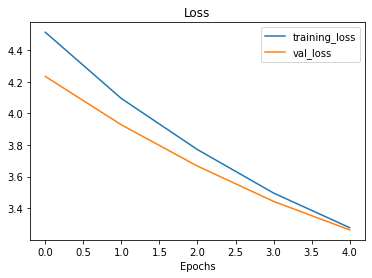

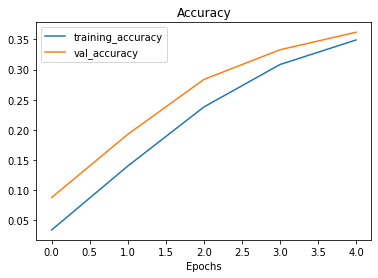

In [18]:
plot_loss_curves(history_all_classes_10_percent)

> Ideally, the two curves should be very similar to each other, if not it may suggest that our model is overfitting (performing too well on the training data and not generalizing to unseen data).

## Fine Tuning

In [ ]:
#Unfreeze all of the layers in the base model
base_model.trainable = True

#Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False